In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [50]:
import glob
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import albumentations
from PIL import Image
import io
import matplotlib.pyplot as plt

In [3]:
train_files = glob.glob('../input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec')

In [17]:
feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}



In [62]:
class PetalDataset(Dataset):
    def __init__(self,image_files):
        self.image_files = image_files
        self.features = {
            'id': tf.io.FixedLenFeature([], tf.string),
            'class': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
            }
        self.image_dataset = tf.data.TFRecordDataset(self.image_files)
        self.image_dataset = self.image_dataset.map(_parse_function)
        self.indexed_data = self._create_indexed_data(self.image_dataset)
        self.aug = albumentations.Compose([
            albumentations.Resize(228,228,always_apply=True),
            albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
      return tf.io.parse_single_example(example_proto, feature_description)
    
    def _create_indexed_data(self,image_dataset):
        indexed_data = []
        for image_data in image_dataset:
            clazz = int(image_data['class'].numpy())
            id = str(image_data['id'].numpy())[2:-1]
            image = image_data['image'].numpy()
            indexed_data.append({'class':clazz,'id':id,'img':image})
        return indexed_data
    
    def __len__(self):
        return len(self.indexed_data)
        
    def __getitem__(self,index):
        item = self.indexed_data[index]
        img = item['img']
        img = np.array(Image.open(io.BytesIO(img)))
        img = self.aug(image = img)['image']
        img = np.transpose(img,(2,0,1)).astype(np.float32)
        img = torch.tensor(img,dtype=torch.float)
        return item['class'],img    
        

In [63]:
train_dataset = PetalDataset(train_files)

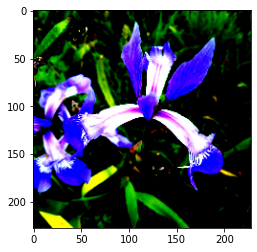

In [66]:
plt.imshow(train_dataset[1][1].permute([1,2,0]))